# ベイズ勉強会 Part 8 ポアソン混合モデル

> ポアソン混合モデルの近似推論

- toc: true 
- badges: true
- comments: true
- categories: [bayes]
- image: images/dag1.png

ベイズ勉強会資料は『ベイズ推論による機械学習入門』{% fn 1 %}を元に、途中式計算をできるだけ省略せずに行ったものです。

In [108]:
# 使うパッケージ
using Distributions
using StatsBase
using LinearAlgebra
using Plots
using StatsPlots
using Flux: onehot

## 登場する確率分布(再掲)

### カテゴリ分布

カテゴリ分布は次のような確率質量関数を分布関数にもつ確率分布である。

$$
Cat({\bf s}|{\bf \pi}) = \Pi_{k=1}^{K} \pi_k^{s_k}
$$

${\bf s}$はK次元ベクトルで、該当カテゴリのみを1,それ以外を0で表したものである(1 of K 表現)。例えば、サイコロの目を確率変数とすれば$s = 5$と書く代わりに、${\bf s} = (0,0,0,0,1,0)^\mathrm{T}$と書く。パラメータ${\bf \pi} = (\pi_1,\dots,\pi_K)^\mathrm{T}$は各カテゴリに配される確率を表したものであり、$\pi_k \in (0,1)$かつ$\Sigma_{k=1}^{K} \pi_k = 1$を満たす。

対数をとると

$$
\ln Cat({\bf s}|{\bf \pi}) = \Sigma_{k=1}^{K} s_k \ln \pi_k
$$

となる。

### ディリクレ分布

尤度関数にカテゴリ分布をとった場合、パラメータ${\bf \pi}$の事前分布は、$\pi_k \in (0,1)$かつ$\Sigma_{k=1}^{K} \pi_k = 1$を満たすK次元ベクトルを出力する必要がある。このような分布として、ディリクレ分布がある。ディリクレ分布の分布関数は次のようになる。

$$
Dir({\bf \pi}|{\bf \alpha}) = C_D ({\bf \alpha}) \Pi_{k=1}^{K} \pi_k^{\alpha_k - 1}
$$

ディリクレ分布のパラメータ${\bf \alpha} = (\alpha_1, \dots, \alpha_K)^\mathrm{T}$の要素$\alpha_k$は正の実数である。正規化係数は

$$
C_D ({\bf \alpha}) = \frac{\Gamma (\Sigma_{k=1}^{K} \alpha_k)}{\Pi_{k=1}^{K} \Gamma (\alpha_k)}
$$

である。

対数をとると

$$
\ln Dir({\bf \pi}|{\bf \alpha}) = \Sigma_{k=1}^{K} (\alpha_k - 1) \ln \pi_k + \ln C_D ({\bf \alpha})
$$

となる。

### ポアソン分布

ポアソン分布は次のような確率密度関数を分布関数にもつ確率分布である。

$$
\mathrm{Poi} (x|\lambda) = \frac{\lambda^x}{x!} \mathrm{e}^{-\lambda}
$$

xは非負の整数、パラメータ$\lambda$は正の実数である。

対数をとると

$$
\ln \mathrm{Poi} (x|\lambda) = x \ln \lambda - \ln x! - \lambda
$$

である。

### ガンマ分布

ポアソン分布のパラメータ$\lambda$は正の実数であるので、事前分布$p(\lambda)$はガンマ分布で表すと都合が良い。ガンマ分布は次のような確率密度関数を分布関数にもつ確率分布である。

$$
\mathrm{Gam}(\lambda|a,b) = C_G(a,b)\lambda^{a-1} \mathrm{e}^{-b\lambda}
$$

正規化係数$C_G(a,b)$は次のような関数である。

$$
C_G(a,b) = \frac{b^a}{\Gamma(a)}
$$

ガンマ分布の対数をとると

$$
\ln \mathrm{Gam}(\lambda|a,b) = (a-1)\ln \lambda - b\lambda + \ln C_G(a,b)
$$

である。

## モデル構築

これまでは次のような1峰性の分布の密度推定をするモデルを扱ってきた。

$$
\begin{eqnarray}
p({\bf X},\lambda) &=& p({\bf X}|\lambda)p(\lambda) \\
ただし　p({\bf X}) &=& \Pi_{n=1}^{N} \mathrm{Poi}(x_n|\lambda) \\
p(\lambda) &=& \mathrm{Gam}(\lambda|a,b)
\end{eqnarray}
$$

In [6]:
# ポアソン分布による密度推定用のモデル
mutable struct PoisModel
    a::Float64
    b::Float64
end

In [7]:
# 事前予測分布を計算する関数
function predict(model::PoisModel)
    r = model.a
    p = 1 / (model.b + 1)
    predict_dist = NegativeBinomial(r, p)
    return predict_dist
end

predict (generic function with 1 method)

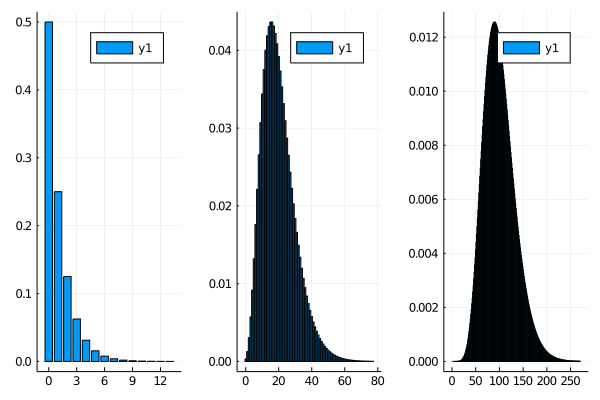

In [21]:
# ハイパーパラメータの値を変えても、1峰性であることは変わらない
p1 = bar(predict(PoisModel(1,1)))
p2 = bar(predict(PoisModel(5,4)))
p3 = bar(predict(PoisModel(10,10)))
plot(p1,p2,p3,layout=(1,3))

このモデルには次のような多峰性の分布を持つデータを表現することができないという欠点がある。

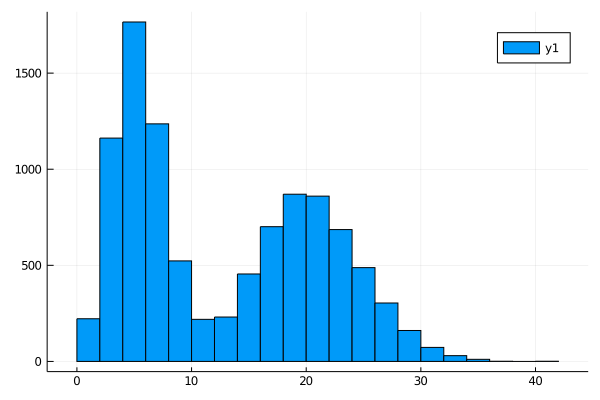

In [67]:
# λ=5とλ=20のポアソン分布から半々の確率で生成したデータ点
Ys = []
for i in 1:10000
    K = rand(Categorical([0.5,0.5]))
    λ = ifelse(K==1,5,20)
    Y = rand(Poisson(λ))
    push!(Ys,Y)
end
histogram(Ys)

そこで、「データを複数のクラスタ(集団)に分けることができ、クラスタごとに異なるポアソン分布から生成されている」という仮定をおいてみることにする。これはカテゴリ分布とポアソン分布を組み合わせることで実現できる。

モデルにおけるN個のデータ点${\bf X} = \{ x_1,\dots,x_N \}$の生成過程を記述すると次(参考資料より引用{% fn 1 %})のようになる。クラスタ数Kは既知とする。

1. それぞれのクラスタの混合比率${\bf \pi} = (\pi_1,\dots,\pi_K)^\mathrm{T}$が事前分布$p({\bf \pi})$から生成される（ただし$\pi_k \in (0,1)$かつ$\Sigma_{k=1}^{K} \pi_k=1$）。
2. それぞれのクラスタ$k=1,\dots,K$に対する観測モデルのパラメータ$\theta_k$（平均や分散）が事前分布$p(\theta_k)$から生成される。
3. $n=1,\dots,N$に関して、$x_n$に対するクラスタの割当$s_n$が比率${\bf \pi}$によって選ばれる。
4. $n=1,\dots,N$に関して、$s_n$によって選択されたk番目の確率分布$p(x_n|\theta_k)$からデータ点$x_n$が生成される。

この生成過程を同時分布の形で書くと次のようになる。$s_n$を1 of K表現で表し、${\bf S} = \{ s_1,\dots,s_N \}$とする。

$$
\begin{eqnarray}
    p({\bf X},{\bf S},{\bf \lambda},{\bf \pi}) &=& p({\bf X}|{\bf S},{\bf \lambda})p({\bf S}|{\bf \pi})p({\bf \lambda})p({\bf \pi}) \\
    &=& \{ \Pi_{n=1}^{N} p(x_n|s_n,{\bf \lambda})p(s_n|{\bf \pi}) \} \{ \Pi_{k=1}^{K} p(\lambda_k) \} p({\bf \pi}) \\
    ただし　p({\bf \pi}) &=& \mathrm{Dir}({\bf \pi}|{\bf \alpha}) \\
    p(\lambda_k) &=& \mathrm{Gam}(\lambda_k|a,b) \\
    p(x_n|s_n,{\bf \lambda}) &=& \Pi_{k=1}^{K} \mathrm{Poi}(x_n|\lambda_k)^{s_{n,k} }
\end{eqnarray}
$$

このようにモデルの生成過程に対する仮定を元に記述したモデルを生成モデルと呼ぶ。また、直接観測されることのないカテゴリ変数$s_n$を隠れ変数または潜在変数と呼ぶ。

以下ではこのモデルの出力がどのようになるかをハイパーパラメータを変えてシミュレーションしている。

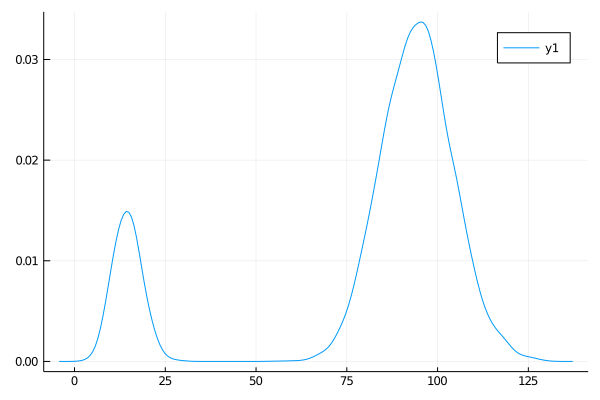

In [65]:
# カテゴリ数を3とする
λs = rand.([Gamma(1,1), Gamma(5,5), Gamma(10,10)])
pi = rand(Dirichlet([0.01,0.19,0.80]))
Ys = []
for i in 1:10000
    s = rand(Categorical(pi))
    λ = λs[s]
    Y = rand(Poisson(λ))
    push!(Ys,Y)
end
density(Ys)

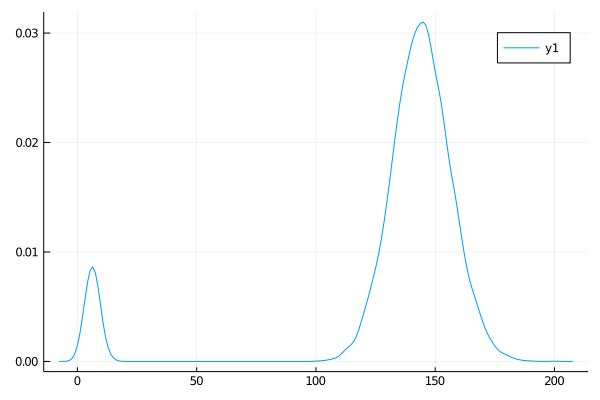

In [62]:
# カテゴリ数を3とする
λs = rand.([Gamma(1,1), Gamma(2,3), Gamma(10,10)])
pi = rand(Dirichlet([0.25,0.20,0.55]))
Ys = []
for i in 1:10000
    s = rand(Categorical(pi))
    λ = λs[s]
    Y = rand(Poisson(λ))
    push!(Ys,Y)
end
density(Ys)

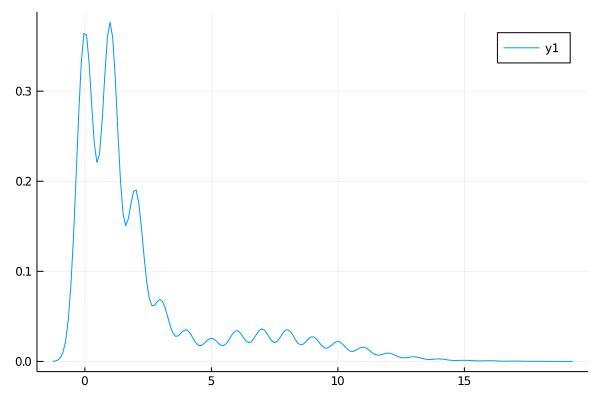

In [61]:
# カテゴリ数を3とする
λs = rand.([Gamma(1,1), Gamma(5,1), Gamma(10,1)])
pi = rand(Dirichlet([0.33,0.34,0.33]))
Ys = []
for i in 1:10000
    s = rand(Categorical(pi))
    λ = λs[s]
    Y = rand(Poisson(λ))
    push!(Ys,Y)
end
density(Ys)

ハイパーパラメータの値を適当に変えることで、多彩な表現ができることがわかる。

## 事後分布の推論に近似推論が必要な理由

同時分布の形で書いているので、事後分布は観測された変数${\bf X}$の分布で割れば求まる。

$$
p({\bf S},{\bf \lambda},{\bf \pi}|{\bf X}) = \frac{p({\bf X},{\bf S},{\bf \lambda},{\bf \pi})}{p({\bf X})}
$$

しかしこれを計算することは現実的には困難であることが知られている。分母の$p({\bf X})$を計算しようとすると、

$$
\begin{eqnarray}
    p({\bf X}) &=& \Sigma_{S} \int \int p({\bf X},{\bf S},{\bf \lambda},{\bf \pi}) d {\bf \lambda} d {\bf \pi} \\
    &=& \Sigma_{S} p({\bf X},{\bf S})
\end{eqnarray}
$$

を解くことになるが、共役事前分布を使うことによりパラメータ${\bf \lambda},{\bf \pi}$については解析的に積分除去可能になるが、$p({\bf X},{\bf S})$を${\bf S}$のとりうる全ての組み合わせについて計算する必要がある。N個の要素がK個のクラスタに分類されるので$K^N$回計算する必要があり、現実的に不可能な計算量になってしまう。そこでMCMC,変分推論といった近似推論手法を用いる必要がある。

## ギブスサンプリング

上でも行っているように、確率分布の特徴は実際にサンプルすることでわかってくる。MCMC法の1種であるギブスサンプリングでは、モデルが複雑なため同時にサンプルすることが難しい各確率変数を、順番にサンプルしていく。

例えば、確率分布$p(z_1,z_2,z_3)$があったときに、一度に$z_1^{(i)},z_2^{(i)},z_3^{(i)} \sim p$とするのは困難であるとする。そのとき、i個目の各変数を次のように順番にサンプルしていくことを考える。

$$
\begin{eqnarray}
    z_1^{(i)} &\sim& p(z_1|z_2^{(i-1)},z_3^{(i-1)}) \\
    z_2^{(i)} &\sim& p(z_2|z_1^{(i)}, z_3^{(i-1)}) \\
    z_3^{(i)} &\sim& p(z_3|z_1^{(i)}, z_2^{(i)})
\end{eqnarray}
$$

1個前の値を使うことで分布を条件づけし簡単な確率分布を得るというアイデアである。$z_1^{1}$をサンプルするために$z_2^{0}, z_3^{0}$は何らかのランダムな初期値を与えてやるのが一般的である。

## ポアソン混合モデルのギブスサンプリング

データ${\bf X}$が観測された後の条件つき分布は

$$
p({\bf S},{\bf \lambda},{\bf \pi}|{\bf X})
$$

となる。この分布は複雑であるため直接${\bf S},{\bf \lambda},{\bf \pi}$をサンプルすることは難しい。混合分布の場合は潜在変数とパラメータを分けてサンプルすると十分に簡単な確率分布が得られることが知られているので、以下の戦略で各確率変数をサンプルしていく。

$$
\begin{eqnarray}
    {\bf S} &\sim& p({\bf S}|{\bf X},{\bf \lambda},{\bf \pi}) \\
    {\bf \lambda}, {\bf \pi} &\sim& p({\bf \lambda},{\bf \pi}|{\bf X},{\bf S})
\end{eqnarray}
$$

### 潜在変数${\bf S}$をサンプルする分布

まず潜在変数${\bf S}$をサンプルするための条件付き分布を求める。ここでは、パラメータ${\bf \lambda}, {\bf \pi}$も与えられていると考える。

$$
\begin{eqnarray}
    p({\bf S}|{\bf X},{\bf \lambda},{\bf \pi}) &\propto& p({\bf S},{\bf \lambda},{\bf \pi}|{\bf X})　(分母は{\bf S}に関わらない) \\
    &\propto& p({\bf X}|{\bf S},{\bf \lambda})p({\bf S}|{\bf \pi})　(p({\bf \lambda}),p({\bf \pi})は{\bf S}に関わらない) \\
    &=& \Pi_{n=1}^{N} p(x_n|s_n,{\bf \lambda})p(s_n|{\bf \pi})
\end{eqnarray}
$$

結果、$p({\bf S}|{\bf X},{\bf \lambda},{\bf \pi})$は各$s_1,\dots,s_N$の分布の積に比例する、つまり条件付き独立な分布に分解できることがわかる。

具体的に、$s_n$をサンプルするための確率分布を計算してみる。指数部分の計算になるので対数をとる。

$$
\begin{eqnarray}
    \ln p(x_n|s_n,{\bf \lambda}) &=& \Sigma_{k=1}^{K} s_{n,k} \ln \mathrm{Poi}(x_n|\lambda_k) \\
    &=& \Sigma_{k=1}^{K} s_{n,k} (x_n \ln \lambda_k - \lambda_k) + const.
\end{eqnarray}
$$

また、

$$
\begin{eqnarray}
    \ln p(s_n|{\bf \pi}) &=& \ln \mathrm{Cat}(s_n|{\bf \pi}) \\
    &=& \Sigma_{k=1}^{K} s_{n,k} \ln \pi_k
\end{eqnarray}
$$

ゆえ

$$
\ln p(x_n|s_n,{\bf \lambda})p(s_n|{\bf \pi}) = \Sigma_{k=1}^{K} s_{n,k} (x_n \ln \lambda_k - \lambda_k + \ln \pi_k) + const.
$$

ここで、$\Sigma_{k=1}^{K} s_{n,k} = 1$という制約があるのでこれはカテゴリ分布に対数をとった形として見ることができる。よって簡略化のため新しいパラメータ変数$\eta_{n}$を用意すると次のようにまとめられる。

$$
\begin{eqnarray}
    s_n &\sim& \mathrm{Cat}(s_n|\eta_n) \\
    ただし　\eta_{n,k} &\propto& \mathrm{exp} \{ x_n \ln \lambda_k - \lambda_k + \ln \pi_k \}　( s.t. \Sigma_{k=1}^{K} \eta_{n,k} = 1 )
\end{eqnarray}
$$

このように各nで$\eta_{n,k}$を計算することにより$s_n$をカテゴリ分布からサンプルできる。

### パラメータ${\bf \lambda},{\bf \pi}$をサンプルする分布

今度は潜在変数${\bf S}$を観測された値のように扱う。

$$
\begin{eqnarray}
    p({\bf \lambda},{\bf \pi}|{\bf X},{\bf S}) &\propto& p({\bf S},{\bf \lambda},{\bf \pi}|{\bf X}) \\
    &=& p({\bf X}|{\bf S},{\bf \lambda})p({\bf S}|{\bf \pi})p({\lambda})p({\bf \pi})
\end{eqnarray}
$$

このとき、${\bf \lambda},{\bf \pi}$に関する項は別々に分解できている。${\bf X}, {\bf S}$が与えられた条件下では独立となっているということである。

まず${\bf \lambda}$の分布を計算する。対数をとって

$$
\begin{eqnarray}
    \ln p({\bf X}|{\bf S},{\bf \lambda}) &=& \Sigma_{n=1}^{N} \Sigma_{k=1}^{K} s_{n,k} \ln \mathrm{Poi}(x_n|\lambda_k) + \Sigma_{k=1}^{K} \ln \mathrm{Gam} (\lambda_k|a,b) \\
    &=& \Sigma_{k=1}^{K} \left\{ (\Sigma_{n=1}^{N} s_{n,k} x_n + a - 1) \ln \lambda_k - (\Sigma_{n=1}^{N} s_{n,k} + b) \lambda_k \right\} + const.
\end{eqnarray}
$$

これは独立したK個のガンマ分布の積に対数をとった形であり、$\lambda_k$は次のガンマ分布からサンプルされる。

$$
\begin{eqnarray}
    \lambda_k &\sim& \mathrm{Gam}(\lambda_k|\hat{a}_k,\hat{b}_k) \\
    ただし　\hat{a}_k &=& \Sigma_{n=1}^{N} s_{n,k} x_n + a \\
    \hat{b}_k &=& \Sigma_{n=1}^{N} s_{n,k} + b
\end{eqnarray}
$$

次に、${\bf \pi}$の分布を計算する。対数をとって

$$
\begin{eqnarray}
    \ln p({\bf S}|{\bf \pi})p({\bf \pi}) &=& \Sigma_{n=1}^{N} \ln \mathrm{Cat}(s_n|{\bf \pi}) \\
    &=& \Sigma_{k=1}^{K} (\Sigma_{n=1}^{N} s_{n,k} + \alpha_k - 1) \ln \pi_k + const.
\end{eqnarray}
$$

となり、${\bf \pi}$は次のディリクレ分布からサンプルできる。

$$
\begin{eqnarray}
    {\bf \pi} &\sim& \mathrm{Dir}({\bf \pi}|\hat{\bf \alpha}) \\
    ただし　\hat{\alpha}_k &=& \Sigma_{n=1}^{N} s_{n,k} + \alpha_k
\end{eqnarray}
$$

### Juliaによる実装

以上をJuliaにより実装する。

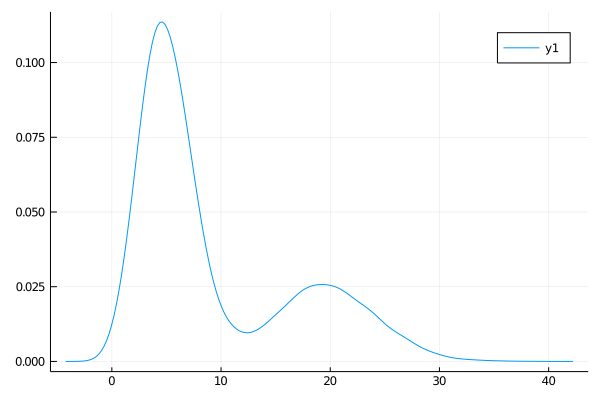

In [103]:
# データ点作成
# λ=5とλ=20のポアソン分布から7:3の確率で生成したデータ点
Ys = []
for i in 1:10000
    K = rand(Categorical([0.7,0.3]))
    λ = ifelse(K==1,5,20)
    Y = rand(Poisson(λ))
    push!(Ys,Y)
end
density(Ys)

In [135]:
# ギブスサンプリングを実行

# chain数は4とする
N = length(X)
K = 2
n_chain = 4
S_mcmc = []
lambda_mcmc = []
pi_mcmc = []

for i in 1:n_chain
    a = [1.,1.]
    b = [1.,1.]
    alpha = [1/2,1/2]
    lambda = abs.(rand(MultivariateNormal([1.,1.],I(2))))
    pi = rand(Dirichlet([1/2,1/2]))

    S_chain = []
    lambda_chain = []
    pi_chain = []

    @time for i in 1:1000
        S = []
        for n in 1:N
            eta_n = exp.(X[n] .* log.(lambda) .- lambda .+ log.(pi))
            eta_n = eta_n ./ sum(eta_n) # 合計が1になるように合計値で割る
            s_n = rand(Categorical(eta_n))
            s_n = onehot(s_n, [1,2])
            push!(S, s_n)
        end
        global a = sum(S.*X) .+ a
        global b = sum(S) .+ b
        global lambda = rand.(Gamma.(a,1 ./ b))
        global alpha = sum(S) .+ alpha
        global pi = rand(Dirichlet(alpha))
        push!(S_chain, S)
        push!(lambda_chain, lambda)
        push!(pi_chain, pi)
    end
    push!(S_mcmc, S_chain)
    push!(lambda_mcmc, lambda_chain)
    push!(pi_mcmc, pi_chain)
end

 68.429917 seconds (288.51 M allocations: 11.473 GiB, 13.10% gc time)
 62.772584 seconds (288.51 M allocations: 11.473 GiB, 10.10% gc time)
 67.760646 seconds (288.51 M allocations: 11.473 GiB, 18.04% gc time)
 62.579098 seconds (288.51 M allocations: 11.473 GiB, 12.61% gc time)


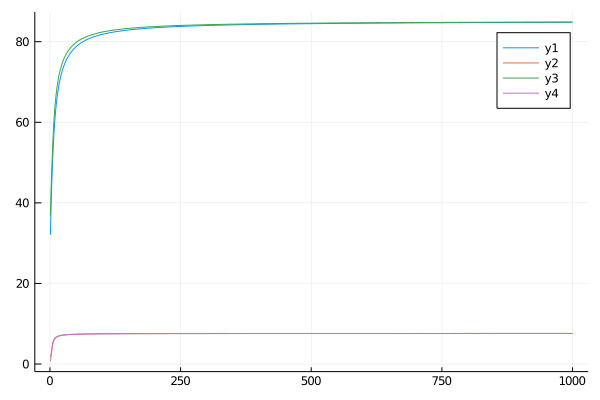

In [136]:
# クラスタ1に対するlambda
plot(1:1000,[l[1] for l in lambda_mcmc[1]])
plot!(1:1000,[l[1] for l in lambda_mcmc[2]])
plot!(1:1000,[l[1] for l in lambda_mcmc[3]])
plot!(1:1000,[l[1] for l in lambda_mcmc[4]])

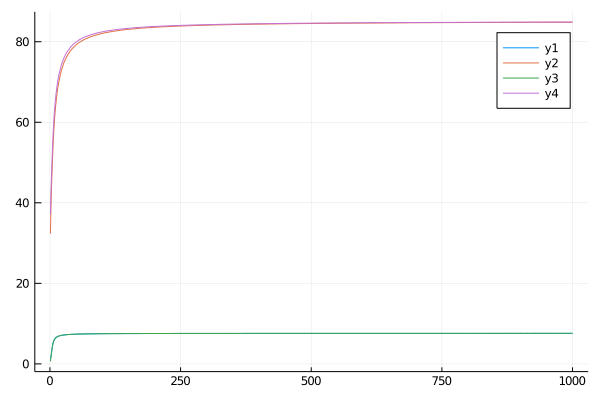

In [137]:
# クラスタ2に対するlambda
plot(1:1000,[l[2] for l in lambda_mcmc[1]])
plot!(1:1000,[l[2] for l in lambda_mcmc[2]])
plot!(1:1000,[l[2] for l in lambda_mcmc[3]])
plot!(1:1000,[l[2] for l in lambda_mcmc[4]])

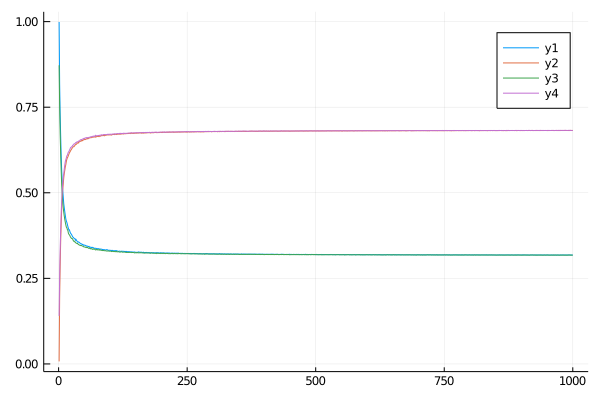

In [138]:
# クラスタ1に割り振られる確率
plot(1:1000,[p[1] for p in pi_mcmc[1]])
plot!(1:1000,[p[1] for p in pi_mcmc[2]])
plot!(1:1000,[p[1] for p in pi_mcmc[3]])
plot!(1:1000,[p[1] for p in pi_mcmc[4]])

**全然収束してませんね！**

まぁこんなもんですよ。うん。

{{ '[須山敦志. 杉山将. ベイズ推論による機械学習入門. 講談社, 2017.](https://www.kspub.co.jp/book/detail/1538320.html)' | fndetail: 1 }}